# Session 10 - Multiple Hidden layers, Dropout, L2 regularization and ADAM

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

<p style="font-family: Arial; font-size:1.2em;color:black;">
By Pramod Sharma : pramod.sharma@prasami.com
<p>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn import datasets, linear_model

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler

import shutil

%matplotlib inline

In [3]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
EPOCHS = 30000 # number of cycles to run

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,6),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams

## Generate Data Set
<p style="font-family: Arial; font-size:1.2em;color:black;">
Lets use Sklearn's dataset generator. To keep the example simple, lets use  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</p>

In [4]:
X, y = datasets.make_moons(n_samples=1280, shuffle=True, noise=0.2, random_state=RANDOM_STATE)

<p style="font-family: Arial; font-size:1.1em;color:brown;">
<strong>Note</strong>: All two dimentional matrix are represented by Caps and all arrays (vectors) are represented by small case.
</p>

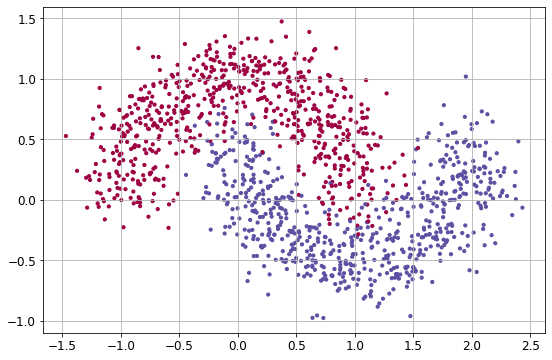

In [5]:
# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=10, c=y, cmap=plt.cm.Spectral)

plt.grid()

In [6]:
def fn_plot_decision_boundary(pred_func, X, y):
    '''
        Attribite
           pred_func : function based on predict method of the classifier
       
       Return:
           None           
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')

In [7]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024,) (256, 2) (256,)


# ADAM


<img src='../Presentations/images/S10/adam_algorithm.jpg' style='width: 800px'/>

In [8]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X, y):
    
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    Z1 = X.dot(W1) + b1 
    A1 = np.tanh(Z1)    # tanh activation
    assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"

    # Layer 2
    Z2 = A1.dot(W2) + b2 
    A2 = np.tanh(Z2)    # tanh activation
    assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"

    # Layer 3
    Z3 = A2.dot(W3) + b3 
    A3 = np.tanh(Z3)    # tanh activation
    assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

    # Layer 4
    Z4 = A3.dot(W4) + b4 
    A4 = np.tanh(Z4)    # tanh activation
    assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"


    Z5 = A4.dot(W5) + b5
    exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    #*************************************
        
    # Calculating the loss
    # Cross entropy = ground truth x log (predicted)
    # probability of y being correct is 1. hence it will be a vector of [1,1,...,1,1]
    # correct_logprobs = -( y * np.log(probs) + (1-y) * np.log (1-probs)) 
    correct_logprobs = -np.log(probs[range(num_examples), y]) 
    data_loss = np.sum(correct_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + 
                                 np.sum(np.square(W2)) +
                                 np.sum(np.square(W3)) +
                                 np.sum(np.square(W4)) +
                                 np.sum(np.square(W5)))
    
    return 1./num_examples * data_loss

In [9]:
# Helper function to predict an output (0 or 1)

def predict(model, x):
    '''
     Args:
         model
         x: input features
    '''
    # Extract weights and losses from the model
    W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
    b1, b2, b3, b4, b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
    
    #***********************************
    # Layer 1
    Z1 = x.dot(W1) + b1 
    A1 = np.tanh(Z1)    # tanh activation
    assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"

    # Layer 2
    Z2 = A1.dot(W2) + b2 
    A2 = np.tanh(Z2)    # tanh activation
    assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"

    # Layer 3
    Z3 = A2.dot(W3) + b3 
    A3 = np.tanh(Z3)    # tanh activation
    assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

    # Layer 4
    Z4 = A3.dot(W4) + b4 
    A4 = np.tanh(Z4)    # tanh activation
    assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"


    Z5 = A4.dot(W5) + b5
    
    # use softmax
    exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
    
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    #*************************************    
    return np.argmax(probs, axis=1) # pick with one with highest probabilities

In [10]:
def drop_out_forward(A, keep_prob):
    '''
    Args:
        A: A matrix
        keep_prob: probabiity of keeping the nodes 0 < keep_prob < 1
        cache : to keep all parameters to be cached
    '''
    # Implementing drop-outs
    if keep_prob > 0:
        drop_out = np.random.rand(A.shape[0], A.shape[1])
        drop_out = (drop_out < keep_prob).astype(np.float)
        A *= drop_out # makes the nodes 0.0
        A /= keep_prob # Adjustment so that the weights do not over inflate
    return A, drop_out

In [11]:
def drop_out_back(dA, drop_out, keep_prob):
    
    # Implementing drop-outs
    if keep_prob > 0:
        dA *= drop_out
        dA /= keep_prob
    return dA

In [12]:
# prepare the Model

def build_model(param, X, y, num_passes=20000,  print_loss=False):
    
    '''
        nn_hdim : Number of nodes in the hidden layer
        X : Features to train on
        y : Targets to train on
        num_passes : Number of passes through the training data for gradient descent
        print_loss : If True, print the loss every 1000 iterations
    '''
    # set Random Seed
    np.random.seed(RANDOM_STATE)
    
    cache = {} # to retain all values to be cached
    
    # Initialize the parameters to random values. We need to learn these.
    W1 = np.random.randn(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    m_t1 = np.zeros_like(W1) 
    v_t1 = np.zeros_like(W1) 
    
    W2 = np.random.randn(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    m_t2 = np.zeros_like(W2) 
    v_t2 = np.zeros_like(W2) 
    
    W3 = np.random.randn(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    m_t3 = np.zeros_like(W3) 
    v_t3 = np.zeros_like(W3) 
    
    W4 = np.random.randn(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
    m_t4 = np.zeros_like(W4) 
    v_t4 = np.zeros_like(W4) 
    
    W5 = np.random.randn(param['nn_hdim'][4], nn_output_dim) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))
    m_t5 = np.zeros_like(W5) 
    v_t5 = np.zeros_like(W5) 

    # This is what we return at the end
    model = {}
    
    assert (W1.shape == tuple(param['nn_hdim'][0:2])), 'Incorrect shape of W1 :{}'.format(W1.shape)
    
    loss = []
    epoch = []
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        # Layer 1
        Z1 = X.dot(W1) + b1 
        A1 = np.tanh(Z1)    # tanh activation
        A1, drop_out1 = drop_out_forward(A1, keep_prob)
        cache['a1_dropout'] = drop_out1
        assert (Z1.shape == A1.shape),"Shape of Z1 and A1 do not match"
        
        # Layer 2
        Z2 = A1.dot(W2) + b2 
        A2 = np.tanh(Z2)    # tanh activation
        
        A2, drop_out2 = drop_out_forward(A2, keep_prob) # Dropout
        cache['a2_dropout'] = drop_out2
        
        assert (Z2.shape == A2.shape),"Shape of Z2 and A2 do not match"
        
        # Layer 3
        Z3 = A2.dot(W3) + b3 
        A3 = np.tanh(Z3)    # tanh activation
        
        A3,drop_out3 = drop_out_forward(A3, keep_prob) # Dropout
        cache['a3_dropout'] = drop_out3
        
        assert (Z3.shape == A3.shape),"Shape of Z3 and A3 do not match"

        # Layer 4
        Z4 = A3.dot(W4) + b4 
        A4 = np.tanh(Z4)    # tanh activation
        
        A4, drop_out4 = drop_out_forward(A4, keep_prob) # Dropout
        cache['a4_dropout'] = drop_out4
        
        assert (Z4.shape == A4.shape),"Shape of Z4 and A4 do not match"


        Z5 = A4.dot(W5) + b5
        exp_scores = np.exp(Z5) # softmax for final layer as it is binary classification
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        #print ('probs.shape', probs.shape)

        
        # Backpropagation
        delta5 = probs # shape = 1024, 2
        delta5[range(num_examples), y] -= 1 # dL/db = dL/dz = (a-y). 
        #  As Y is single dimension subtract one from its class
        
        # layer 5 # dZ = (a-y) = delta5
        dW5 = (A4.T).dot(delta5) / num_examples 
        db5 = np.sum(delta5, axis=0, keepdims=True) / num_examples # db5 is vertical sum of delta5
        dA4 = delta5.dot(W5.T)
        
        dA4 = drop_out_back(dA4, cache['a4_dropout'], keep_prob) ## drop_layer
        
        assert (dW5.shape == W5.shape),"Shape of dW5 {} and W5 {} do not match".format(dW5.shape, W5.shape)
        assert (dA4.shape == A4.shape),"Shape of dA4 {} and A4 {} do not match".format(dA4.shape, A4.shape)
        
        # Layer 4 **********************************
        dZ4 = dA4 * (1 - np.power(A4, 2))
        assert (dZ4.shape == Z4.shape),"Shape of dZ4 {} and Z4{} do not match".format(dZ4.shape, Z4.shape)
        
        dW4 = (A3.T).dot(dZ4) / num_examples
        assert (dW4.shape == W4.shape),"Shape of dW4 {} and W4 {} do not match".format(dW4.shape, W4.shape)
        
        db4 = np.sum(dZ4, axis=0, keepdims=True) / num_examples 
        dA3= dZ4.dot(W4.T)
        
        dA3 = drop_out_back(dA3, cache['a3_dropout'], keep_prob) ## drop_layer
        
        assert (dA3.shape == A3.shape),"Shape of dA3 {} and A3 {} do not match".format(dA3.shape, A3.shape)

        # Layer 3 **********************************
        dZ3 = dA3 * (1 - np.power(A3, 2))
        assert (dZ3.shape == Z3.shape),"Shape of dZ3 {} and Z3{} do not match".format(dZ3.shape, Z3.shape)
        
        dW3 = (A2.T).dot(dZ3) / num_examples
        assert (dW3.shape == W3.shape),"Shape of dW3 {} and W3 {} do not match".format(dW3.shape, W3.shape)
        
        db3 = np.sum(dZ3, axis=0, keepdims=True) / num_examples 
        dA2= dZ3.dot(W3.T)
        
        dA2 = drop_out_back(dA2, cache['a2_dropout'], keep_prob) ## drop_layer
        
        assert (dA2.shape == A2.shape),"Shape of dA2 {} and A2 {} do not match".format(dA2.shape, A2.shape)

        # Layer 2 **********************************
        dZ2 = dA2 * (1 - np.power(A2, 2))
        assert (dZ2.shape == Z2.shape),"Shape of dZ2 {} and Z2{} do not match".format(dZ2.shape, Z2.shape)
        
        dW2 = (A1.T).dot(dZ2) / num_examples
        assert (dW2.shape == W2.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        
        db2 = np.sum(dZ2, axis=0, keepdims=True) / num_examples 
        dA1= dZ2.dot(W2.T)
        
        dA1 = drop_out_back(dA1, cache['a1_dropout'], keep_prob) ## drop_layer
        
        assert (dA1.shape == A1.shape),"Shape of dA1 {} and A1 {} do not match".format(dA1.shape, A1.shape)

        # Layer 1 **********************************
        dZ1 = dA1 * (1 - np.power(A1, 2))
        assert (dZ1.shape == Z1.shape),"Shape of dZ1 {} and Z1{} do not match".format(dZ1.shape, Z1.shape)
        
        dW1 = (X.T).dot(dZ1) / num_examples
        assert (dW1.shape == W1.shape),"Shape of dW2 {} and W2 {} do not match".format(dW2.shape, W2.shape)
        
        db1 = np.sum(dZ1, axis=0, keepdims=True) / num_examples
        assert (db1.shape == b1.shape),"Shape of db1 {} and b1 {} do not match".format(db1.shape, b1.shape)
        #dA0= dZ1.dot(W1.T)
        #assert (dA1.shape == A1.shape),"Shape of dA1 {} and A1 {} do not match".format(dA1.shape, A1.shape)


        # Add regularization terms (b's don't have regularization terms)
        dW5 += reg_lambda * W5 / num_examples
        dW4 += reg_lambda * W4 / num_examples
        dW3 += reg_lambda * W3 / num_examples
        dW2 += reg_lambda * W2 / num_examples
        dW1 += reg_lambda * W1 / num_examples

        # Gradient descent parameter update
        #W1 += -epsilon * dW1
        b1 += -epsilon * db1
        
        #W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        #W3 += -epsilon * dW3
        b3 += -epsilon * db3
        
        #W4 += -epsilon * dW4
        b4 += -epsilon * db4
        
        #W5 += -epsilon * dW5
        b5 += -epsilon * db5
        
        
        W1 += -adam_optimizer(dW1, m_t1, v_t1)
        W2 += -adam_optimizer(dW2, m_t2, v_t2)
        W3 += -adam_optimizer(dW3, m_t3, v_t3)
        W4 += -adam_optimizer(dW4, m_t4, v_t4)
        W5 += -adam_optimizer(dW5, m_t5, v_t5)
        
        # Assign new parameters to the model
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5,}
        
        #Calculate loss after 100 epoch
        if i % 100 == 0:
            curr_loss = calculate_loss(model, X, y)
            epoch.append(i)
            loss.append(curr_loss)

        
        # Print the loss.
        if print_loss and i % 5000 == 0:    
            print("Loss after iteration %i: %f" %(i, curr_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    return model, probs

In [13]:
# define nodes in each of dims
layer_param = {}
layer_param['nn_hdim'] = [X_train.shape[1],5,5,4,3,2]
keep_prob = 0.95

# lists to facilitate plotting 
loss_hist = {}

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent for b only
# Regularization parameters

reg_lambda = 0.01 # regularization strength

###################### Initializing parameters for the ADAM optimiser
#α = 0.001, β_1 = 0.9, β_2 = 0.999 and Adam_epsilon = 10 −8 .
alpha = 0.001
beta_1 = 0.9
beta_2 = 0.999
adam_epsilon = 1e-8

In [14]:
def adam_optimizer(dW, m_t, v_t):
    m_t = beta_1*m_t + (1-beta_1)*dW      #updates the moving averages of the gradient
    v_t = beta_2*v_t + (1-beta_2)*(dW*dW) #updates the moving averages of the squared gradient
    m_cap = m_t/(1-(beta_1))              #calculates the bias-corrected estimate

    v_cap = v_t/(1-(beta_2))		#calculates the bias-corrected estimates
    change = (alpha*m_cap)/(np.sqrt(v_cap)+adam_epsilon)
    #print ('DW', change)
    #print ('----------------------------------')
    return (alpha*m_cap)/(np.sqrt(v_cap)+adam_epsilon)

In [15]:
num_examples = X_train.shape[0] # training set size
#nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Build a model with a 4-dimensional hidden layer
model, probs = build_model(layer_param, X_train, y_train, num_passes = EPOCHS, print_loss=True)

Loss after iteration 0: 0.652955
Loss after iteration 5000: 0.106893
Loss after iteration 10000: 0.102231
Loss after iteration 15000: 0.100360
Loss after iteration 20000: 0.100769
Loss after iteration 25000: 0.100082


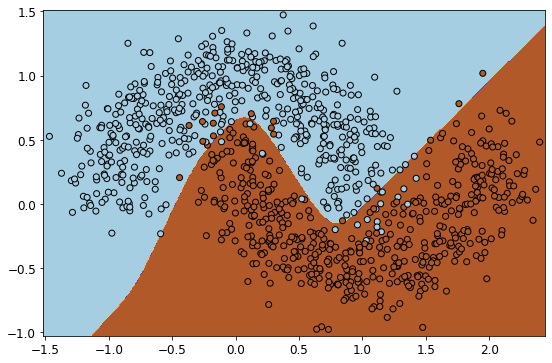

In [16]:
loss_df = pd.DataFrame(loss_hist)
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

In [17]:
def fn_make_predicitions(pred_func, X):
    y_pred = pred_func(X)
    return y_pred

In [18]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_train)
print('Accruacy score on Train Data :', accuracy_score(y_train, y_pred))

#Accruacy score on Train Data : 0.974609375

Accruacy score on Train Data : 0.9638671875


In [19]:
y_pred = fn_make_predicitions(lambda x: predict(model, x), X_test)

print('Accruacy score on Test Data :', accuracy_score(y_test, y_pred))

# Accruacy score on Test Data : 0.95703125

Accruacy score on Test Data : 0.9609375


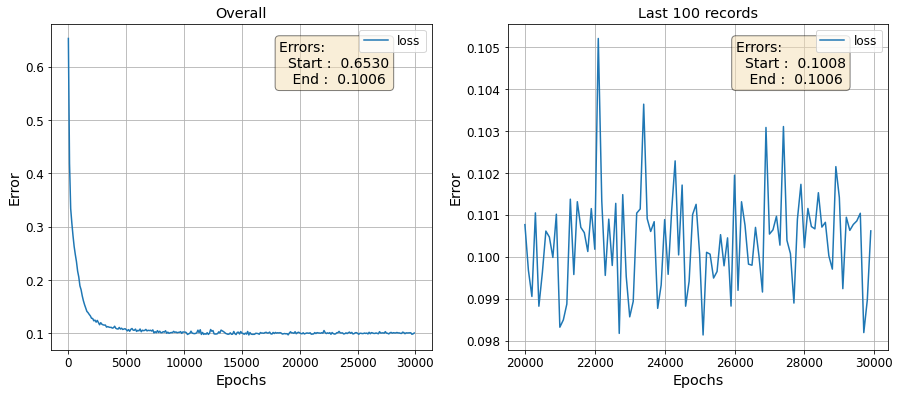

In [20]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
loss = loss_df['loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();